In [1]:
import pandas as pd

In [9]:
data = pd.read_parquet('dataset_modelo_v1.parquet')

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Cargar el archivo
df = data.copy()

# Crear variable objetivo
df['cobroExitoso'] = (df['Descripcion'] == 'Domiciliacion Exitosa').astype(int)

# Seleccionar columnas relevantes
columnas_usables = [
    'idBanco_x', 'montoExigible', 'montoCobrar', 'intentoDeCobro',
    'CANAL DE ENVIO', 'TIPO ENVIO'
]
data_modelo = df[columnas_usables + ['cobroExitoso']].copy()

# Rellenar NaNs
for col in data_modelo.columns:
    if data_modelo[col].dtype == 'object':
        data_modelo[col] = data_modelo[col].fillna('Desconocido')
    else:
        data_modelo[col] = data_modelo[col].fillna(0)

# Codificar variables categóricas
label_encoders = {}
for col in data_modelo.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data_modelo[col] = le.fit_transform(data_modelo[col])
    label_encoders[col] = le

# Separar features y target
X = data_modelo.drop(columns='cobroExitoso')
y = data_modelo['cobroExitoso']

# Dividir datos con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar modelo
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Evaluar modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


/Users/marcelotrevino/miniforge3/envs/venv1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:39:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.97      1.00      0.99   1956219
           1       0.69      0.01      0.02     58781

    accuracy                           0.97   2015000
   macro avg       0.83      0.50      0.50   2015000
weighted avg       0.96      0.97      0.96   2015000

[[1956004     215]
 [  58295     486]]


In [11]:
from sklearn.utils import resample

# Concatenar X y y para trabajar con todo el dataset
data_concat = pd.concat([X, y], axis=1)

# Separar clases
clase_mayoritaria = data_concat[data_concat['cobroExitoso'] == 0]
clase_minoritaria = data_concat[data_concat['cobroExitoso'] == 1]

# Submuestreo (undersampling) de la clase mayoritaria
clase_mayoritaria_downsampled = resample(
    clase_mayoritaria,
    replace=False,
    n_samples=len(clase_minoritaria),
    random_state=42
)

# Combinar ambas clases
data_balanceado = pd.concat([clase_mayoritaria_downsampled, clase_minoritaria])

# Mezclar filas
data_balanceado = data_balanceado.sample(frac=1, random_state=42)

# Separar nuevamente X e y
X_bal = data_balanceado.drop(columns='cobroExitoso')
y_bal = data_balanceado['cobroExitoso']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Entrenar modelo
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Evaluación
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

/Users/marcelotrevino/miniforge3/envs/venv1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:42:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.69      0.75      0.72     58781
           1       0.73      0.66      0.69     58781

    accuracy                           0.71    117562
   macro avg       0.71      0.71      0.71    117562
weighted avg       0.71      0.71      0.71    117562

[[44216 14565]
 [19974 38807]]


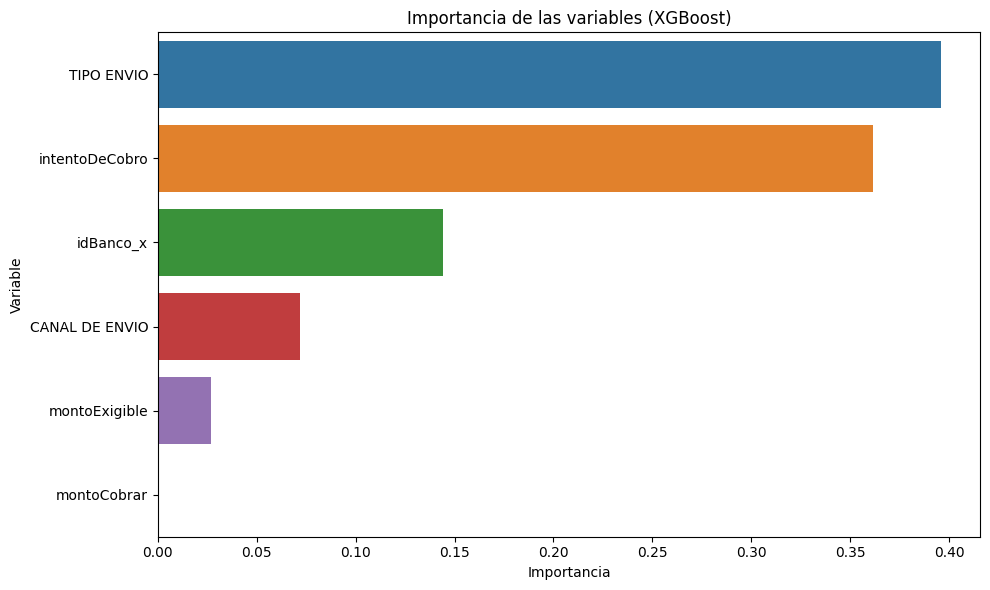

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener importancia de cada variable
importancias = model.feature_importances_
nombres_columnas = X_train.columns

# Crear DataFrame ordenado
df_importancias = pd.DataFrame({
    'feature': nombres_columnas,
    'importance': importancias
}).sort_values(by='importance', ascending=False)

# Visualizar
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=df_importancias)
plt.title('Importancia de las variables (XGBoost)')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

In [17]:
data['TIPO ENVIO'].value_counts()

TIPO ENVIO
CLABE,CUENTA,TARJETA    11706
CLABE                   11706
Name: count, dtype: int64

In [18]:
data[data['TIPO ENVIO'] == 'CLABE']

,idListaCobro,idCredito,consecutivoCobro,idBanco_x,montoExigible,montoCobrar,montoCobrado,fechaCobroBanco,idRespuestaBanco,Banco,...,SERVICIO,CANAL DE ENVIO,TIPO ENVIO,COBROS,inicio_horario_limite_carga_bancaria,FIN HORARIO LIMITE CARGA BANCARIIA,HORARIOS DE COBRO EN BANCO POR DIA,OBSERVACIONES,fin_horario_limite_carga_bancaria,intentoDeCobro
215678,102523,103785,28832390,2,1362.46,1362.46,0.00,None,None,BANAMEX,...,INTERBANCA,BANCA,CLABE,TOTAL Y PARCIAL,08:00:00,14:59,19:00 A 20:00,La respuesta se obtiene al siguiente dia en el...,14:59:00,13
215680,102523,103785,28832390,2,1362.46,1362.46,0.00,None,None,BANAMEX,...,INTERBANCA,H2H,CLABE,TOTAL Y PARCIAL,09:00:00,15:55,19:00 A 20:00,La respuesta se obtiene al siguiente dia en el...,15:55:00,15
221915,102601,103785,28918016,2,1362.46,1362.46,0.00,None,None,BANAMEX,...,INTERBANCA,BANCA,CLABE,TOTAL Y PARCIAL,08:00:00,14:59,19:00 A 20:00,La respuesta se obtiene al siguiente dia en el...,14:59:00,17
221917,102601,103785,28918016,2,1362.46,1362.46,0.00,None,None,BANAMEX,...,INTERBANCA,H2H,CLABE,TOTAL Y PARCIAL,09:00:00,15:55,19:00 A 20:00,La respuesta se obtiene al siguiente dia en el...,15:55:00,19
360487,102698,103785,29101159,2,1362.46,1362.46,0.00,None,None,BANAMEX,...,INTERBANCA,BANCA,CLABE,TOTAL Y PARCIAL,08:00:00,14:59,19:00 A 20:00,La respuesta se obtiene al siguiente dia en el...,14:59:00,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215676,102523,87227,28832748,2,1035.47,1035.47,0.00,None,None,BANAMEX,...,INTERBANCA,H2H,CLABE,TOTAL Y PARCIAL,09:00:00,15:55,19:00 A 20:00,La respuesta se obtiene al siguiente dia en el...,15:55:00,15
221911,102601,87227,28918015,2,1035.47,1035.47,0.00,None,None,BANAMEX,...,INTERBANCA,BANCA,CLABE,TOTAL Y PARCIAL,08:00:00,14:59,19:00 A 20:00,La respuesta se obtiene al siguiente dia en el...,14:59:00,17
221913,102601,87227,28918015,2,1035.47,1035.47,0.00,None,None,BANAMEX,...,INTERBANCA,H2H,CLABE,TOTAL Y PARCIAL,09:00:00,15:55,19:00 A 20:00,La respuesta se obtiene al siguiente dia en el...,15:55:00,19
360483,102698,87227,29101158,2,1035.47,1035.47,0.00,None,None,BANAMEX,...,INTERBANCA,BANCA,CLABE,TOTAL Y PARCIAL,08:00:00,14:59,19:00 A 20:00,La respuesta se obtiene al siguiente dia en el...,14:59:00,24


In [29]:
data = pd.read_parquet('gold.parquet')

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Preparar datos
df = pd.read_parquet('gold.parquet')
df['cobroExitoso'] = (df['DESCRIPCION'] == 'Domiciliacion Exitosa').astype(int)
df['FECHAENVIOCOBRO'] = pd.to_datetime(df['FECHAENVIOCOBRO'], errors='coerce')
df['mes'] = df['FECHAENVIOCOBRO'].dt.month
df['dia_semana'] = df['FECHAENVIOCOBRO'].dt.dayofweek
df['IDEMISORA'] = df['IDEMISORA'].fillna(-1).astype(int)
df['NOMBRE_EMISORA'] = df['NOMBRE_EMISORA'].fillna('Desconocido')
df['IDBANCO_EMISORA'] = df['IDBANCO_EMISORA'].fillna(-1).astype(int)
df['es_mismo_banco'] = (df['IDBANCO_X'] == df['IDBANCO_EMISORA'])

# Historial
df = df.sort_values(by=['IDCREDITO', 'FECHAENVIOCOBRO'])
df['intento_es_reintento'] = df.groupby('IDCREDITO').cumcount() > 0
df['dias_desde_ultimo_intento'] = df.groupby('IDCREDITO')['FECHAENVIOCOBRO'].diff().dt.days.fillna(-1)
df['prev_exitos'] = df.groupby('IDCREDITO')['cobroExitoso'].cumsum() - df['cobroExitoso']
df['tasa_exito_prev'] = df.groupby('IDCREDITO').cumcount()
df['tasa_exito_prev'] = df['prev_exitos'] / df['tasa_exito_prev'].replace(0, 1)

# Emisoras
emisora_frec = df.groupby('IDCREDITO')['NOMBRE_EMISORA'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Desconocido')
df['emisora_frecuente'] = df['IDCREDITO'].map(emisora_frec)
df['es_emisora_frecuente'] = df['NOMBRE_EMISORA'] == df['emisora_frecuente']
segunda_emisoras = df.groupby('IDCREDITO')['NOMBRE_EMISORA'].agg(lambda x: pd.Series(x).dropna().unique()[1] if len(pd.Series(x).dropna().unique()) > 1 else 'none')
df['emisora_segundo_plato'] = df['IDCREDITO'].map(segunda_emisoras)
df['es_emisora_segundo_plato'] = df['NOMBRE_EMISORA'] == df['emisora_segundo_plato']

# Variables del modelo
columnas_modelo = [
    'IDBANCO_X', 'INTENDODECOBRO', 'TIPOENVIO', 'mes', 'dia_semana',
    'IDEMISORA', 'NOMBRE_EMISORA', 'IDBANCO_EMISORA',
    'es_mismo_banco', 'intento_es_reintento', 'dias_desde_ultimo_intento',
    'tasa_exito_prev', 'es_emisora_frecuente', 'es_emisora_segundo_plato',
    'cobroExitoso'
]

data_modelo = df[columnas_modelo].copy()

# Codificar todas las columnas tipo object o string
for col in data_modelo.columns:
    if data_modelo[col].dtype == 'object' or pd.api.types.is_string_dtype(data_modelo[col]):
        data_modelo[col] = pd.factorize(data_modelo[col].fillna('Desconocido'))[0]

for col in data_modelo.columns:
    if data_modelo[col].dtype == 'bool':
        data_modelo[col] = data_modelo[col].astype(int)
    elif data_modelo[col].dtype not in ['int64', 'float64']:
        try:
            data_modelo[col] = data_modelo[col].astype(float)
        except:
            data_modelo[col] = pd.factorize(data_modelo[col].fillna('Desconocido'))[0]


# Verificar que no haya columnas no válidas
assert all([str(t) in ['int64', 'float64'] for t in data_modelo.dtypes]), "❌ Todavía hay columnas inválidas."

# Separar X e y
X = data_modelo.drop(columns='cobroExitoso')
y = data_modelo['cobroExitoso']

# Undersampling
mayoria = X[y == 0]
minoria = X[y == 1]
print("Clase 0:", len(mayoria))
print("Clase 1:", len(minoria))

if len(mayoria) == 0 or len(minoriba) == 0:
    print("❌ Error: una clase está vacía.")
else:
    mayoria_down = resample(mayoria, replace=False, n_samples=len(minoria), random_state=42)
    X_bal = pd.concat([mayoria_down, minoria])
    y_bal = pd.Series([0] * len(mayoria_down) + [1] * len(minoria), name='cobroExitoso')

    # Entrenamiento
    X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, stratify=y_bal, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    # Evaluación
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Clase 0: 9610209
Clase 1: 441378


/Users/marcelotrevino/miniforge3/envs/venv1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:53:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.87      0.91      0.89     88276
           1       0.91      0.87      0.89     88276

    accuracy                           0.89    176552
   macro avg       0.89      0.89      0.89    176552
weighted avg       0.89      0.89      0.89    176552

[[80659  7617]
 [11803 76473]]


In [56]:
data.head()

,IDLISTACOBRO,IDCREDITO,CONSECUTIVOCOBRO,IDBANCO_X,MONTOEXIGIBLE,MONTOCOBRAR,MONTOCOBRADO,IDRESPUESTABANCO,BANCO,DESCRIPCION,IDEMISORA,NOMBRE_EMISORA,IDBANCO_EMISORA,EMISORA,TIPOENVIO,NOMBRE_BANCO_EMISORA,FECHAENVIOCOBRO,ISSUCCESSFUL,INTENDODECOBRO
0,162151,756595,44254121,12,405.23,405.23,0.00,04,BBVA MEXICO,Cuenta Insuficiencia Fondos,6,BBVA TRADICIONAL REINTENTO,12.0,REINTENTO,TRADICIONAL,BBVA MEXICO,2025-05-19,True,1
1,162140,756595,44253034,12,405.23,405.23,0.00,04,BBVA MEXICO,Cuenta Insuficiencia Fondos,6,BBVA TRADICIONAL REINTENTO,12.0,REINTENTO,TRADICIONAL,BBVA MEXICO,2025-05-19,True,2
2,162129,756595,44252393,12,405.23,405.23,0.00,04,BBVA MEXICO,Cuenta Insuficiencia Fondos,21,BBVA CLABE EN LINEA,12.0,07455,EN LINEA,BBVA MEXICO,2025-05-19,True,3
3,162167,756595,44260726,12,405.23,405.23,0.00,04,BBVA MEXICO,Cuenta Insuficiencia Fondos,6,BBVA TRADICIONAL REINTENTO,12.0,REINTENTO,TRADICIONAL,BBVA MEXICO,2025-05-19,True,4
4,162174,756595,44265903,12,405.23,405.23,405.23,00,BBVA MEXICO,Domiciliacion Exitosa,17,BBVA CLABE TRADICIONAL,12.0,07167,TRADICIONAL,BBVA MEXICO,2025-05-19,True,5


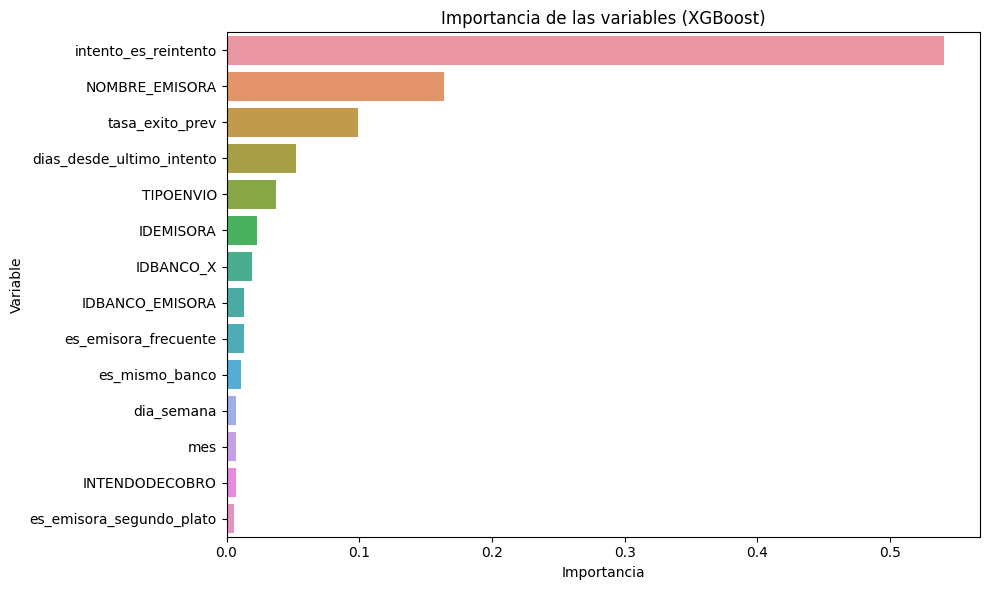

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener importancia de cada variable
importancias = model.feature_importances_
nombres_columnas = X_train.columns

# Crear DataFrame ordenado
df_importancias = pd.DataFrame({
    'feature': nombres_columnas,
    'importance': importancias
}).sort_values(by='importance', ascending=False)

# Visualizar
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=df_importancias)
plt.title('Importancia de las variables (XGBoost)')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Preparar datos
df = pd.read_parquet('gold.parquet')
df['cobroExitoso'] = (df['DESCRIPCION'] == 'Domiciliacion Exitosa').astype(int)
df['FECHAENVIOCOBRO'] = pd.to_datetime(df['FECHAENVIOCOBRO'], errors='coerce')
df['mes'] = df['FECHAENVIOCOBRO'].dt.month
df['dia_semana'] = df['FECHAENVIOCOBRO'].dt.dayofweek
df['IDEMISORA'] = df['IDEMISORA'].fillna(-1).astype(int)
df['NOMBRE_EMISORA'] = df['NOMBRE_EMISORA'].fillna('Desconocido')
df['IDBANCO_EMISORA'] = df['IDBANCO_EMISORA'].fillna(-1).astype(int)
df['es_mismo_banco'] = (df['IDBANCO_X'] == df['IDBANCO_EMISORA'])

# Historial
df = df.sort_values(by=['IDCREDITO', 'FECHAENVIOCOBRO'])
df['intento_es_reintento'] = df.groupby('IDCREDITO').cumcount() > 0
df['dias_desde_ultimo_intento'] = df.groupby('IDCREDITO')['FECHAENVIOCOBRO'].diff().dt.days.fillna(-1)
df['prev_exitos'] = df.groupby('IDCREDITO')['cobroExitoso'].cumsum() - df['cobroExitoso']
df['tasa_exito_prev'] = df.groupby('IDCREDITO').cumcount()
df['tasa_exito_prev'] = df['prev_exitos'] / df['tasa_exito_prev'].replace(0, 1)

# Emisoras
emisora_frec = df.groupby('IDCREDITO')['NOMBRE_EMISORA'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Desconocido')
df['emisora_frecuente'] = df['IDCREDITO'].map(emisora_frec)
df['es_emisora_frecuente'] = df['NOMBRE_EMISORA'] == df['emisora_frecuente']
segunda_emisoras = df.groupby('IDCREDITO')['NOMBRE_EMISORA'].agg(lambda x: pd.Series(x).dropna().unique()[1] if len(pd.Series(x).dropna().unique()) > 1 else 'none')
df['emisora_segundo_plato'] = df['IDCREDITO'].map(segunda_emisoras)
df['es_emisora_segundo_plato'] = df['NOMBRE_EMISORA'] == df['emisora_segundo_plato']

# Asegurar que 'MONTO' exista y sea numérico
df['MONTOEXIGIBLE'] = pd.to_numeric(df['MONTOEXIGIBLE'], errors='coerce').fillna(0)
df['MONTOCOBRAR'] = pd.to_numeric(df['MONTOCOBRAR'], errors='coerce').fillna(0)

# Variables del modelo
columnas_modelo = [
    'IDBANCO_X', 'INTENDODECOBRO', 'TIPOENVIO', 'mes', 'dia_semana',
    'IDEMISORA', 'NOMBRE_EMISORA', 'IDBANCO_EMISORA',
    'es_mismo_banco', 'intento_es_reintento', 'dias_desde_ultimo_intento',
    'tasa_exito_prev', 'es_emisora_frecuente', 'es_emisora_segundo_plato',
    'MONTOEXIGIBLE', 'MONTOCOBRAR', 'cobroExitoso'
]

data_modelo = df[columnas_modelo].copy()

# Codificar todas las columnas tipo object o string
for col in data_modelo.columns:
    if data_modelo[col].dtype == 'object' or pd.api.types.is_string_dtype(data_modelo[col]):
        data_modelo[col] = pd.factorize(data_modelo[col].fillna('Desconocido'))[0]

for col in data_modelo.columns:
    if data_modelo[col].dtype == 'bool':
        data_modelo[col] = data_modelo[col].astype(int)
    elif data_modelo[col].dtype not in ['int64', 'float64']:
        try:
            data_modelo[col] = data_modelo[col].astype(float)
        except:
            data_modelo[col] = pd.factorize(data_modelo[col].fillna('Desconocido'))[0]

# Verificar que no haya columnas no válidas
assert all([str(t) in ['int64', 'float64'] for t in data_modelo.dtypes]), "❌ Todavía hay columnas inválidas."

# Separar X e y
X = data_modelo.drop(columns='cobroExitoso')
y = data_modelo['cobroExitoso']

# Undersampling
mayoria = X[y == 0]
minoria = X[y == 1]
print("Clase 0:", len(mayoria))
print("Clase 1:", len(minoria))

if len(mayoria) == 0 or len(minoria) == 0:
    print("❌ Error: una clase está vacía.")
else:
    mayoria_down = resample(mayoria, replace=False, n_samples=len(minoria), random_state=42)
    X_bal = pd.concat([mayoria_down, minoria])
    y_bal = pd.Series([0] * len(mayoria_down) + [1] * len(minoria), name='cobroExitoso')

    # Entrenamiento
    X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, stratify=y_bal, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    # Evaluación
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Clase 0: 9610209
Clase 1: 441378


/Users/marcelotrevino/miniforge3/envs/venv1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:11:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.88      0.91      0.89     88276
           1       0.91      0.87      0.89     88276

    accuracy                           0.89    176552
   macro avg       0.89      0.89      0.89    176552
weighted avg       0.89      0.89      0.89    176552

[[80362  7914]
 [11478 76798]]


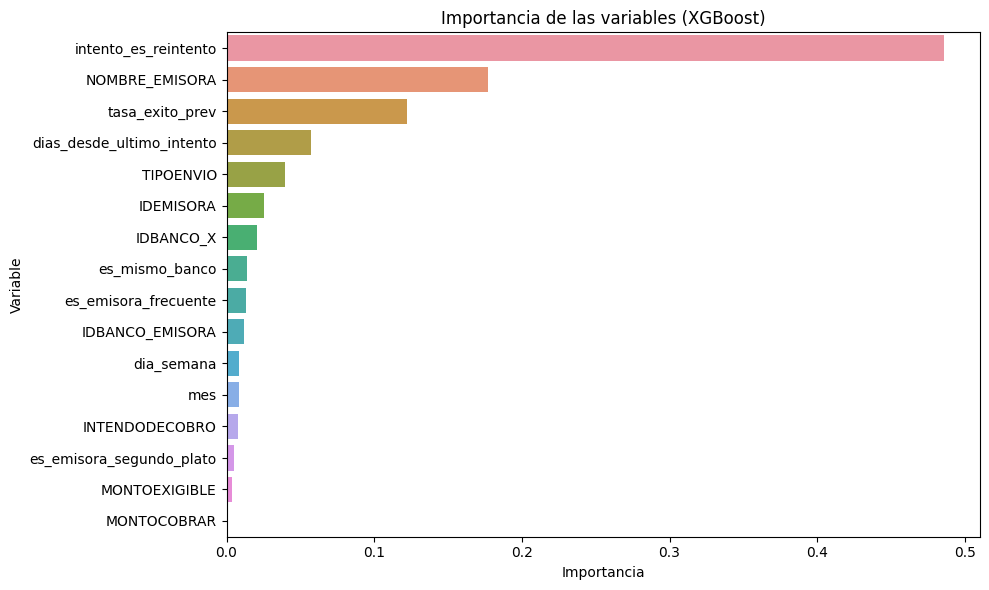

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener importancia de cada variable
importancias = model.feature_importances_
nombres_columnas = X_train.columns

# Crear DataFrame ordenado
df_importancias = pd.DataFrame({
    'feature': nombres_columnas,
    'importance': importancias
}).sort_values(by='importance', ascending=False)

# Visualizar
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=df_importancias)
plt.title('Importancia de las variables (XGBoost)')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def graficar_desempeno(df, frac=0.05):
    # Optimización de tipos
    df['intento_es_reintento'] = df['intento_es_reintento'].astype('int8')
    df['cobroExitoso'] = df['cobroExitoso'].astype('int8')
    df['NOMBRE_EMISORA'] = df['NOMBRE_EMISORA'].astype('category')
    
    # Crear muestra
    df_m = df.sample(frac=frac, random_state=42)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_m, x='intento_es_reintento', y='cobroExitoso')
    plt.xticks([0, 1], ['Primer intento', 'Reintento'])
    plt.title('Éxito por tipo de intento')
    plt.xlabel('')
    plt.ylabel('Tasa de éxito')
    plt.show()
    
    top_emisoras = df_m['NOMBRE_EMISORA'].value_counts().head(10).index
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_m[df_m['NOMBRE_EMISORA'].isin(top_emisoras)],
                y='NOMBRE_EMISORA', x='cobroExitoso', estimator='mean')
    plt.title('Tasa de éxito por emisora (Top 10)')
    plt.xlabel('Tasa de éxito')
    plt.ylabel('Emisora')
    plt.show()

    df_m['grupo_dias'] = pd.cut(df_m['dias_desde_ultimo_intento'], bins=[-2, 0, 2, 5, 10, 20, 1000])
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_m, x='grupo_dias', y='cobroExitoso')
    plt.title('Tasa de éxito según días desde el último intento')
    plt.xlabel('Días desde último intento')
    plt.ylabel('Tasa de éxito')
    plt.xticks(rotation=45)
    plt.show()
    
    df_m['rango_monto'] = pd.qcut(df_m['MONTOEXIGIBLE'], q=5, duplicates='drop')
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_m, x='rango_monto', y='cobroExitoso')
    plt.title('Tasa de éxito según monto a cobrar')
    plt.xlabel('Monto (quintiles)')
    plt.ylabel('Tasa de éxito')
    plt.xticks(rotation=45)
    plt.show()
    
    df_m['grupo_historial'] = pd.cut(df_m['tasa_exito_prev'], bins=[-0.1, 0, 0.25, 0.5, 0.75, 1])
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_m, x='grupo_historial', y='cobroExitoso')
    plt.title('Tasa de éxito según historial previo')
    plt.xlabel('Tasa de éxito previa')
    plt.ylabel('Tasa de éxito actual')
    plt.xticks(rotation=45)
    plt.show()

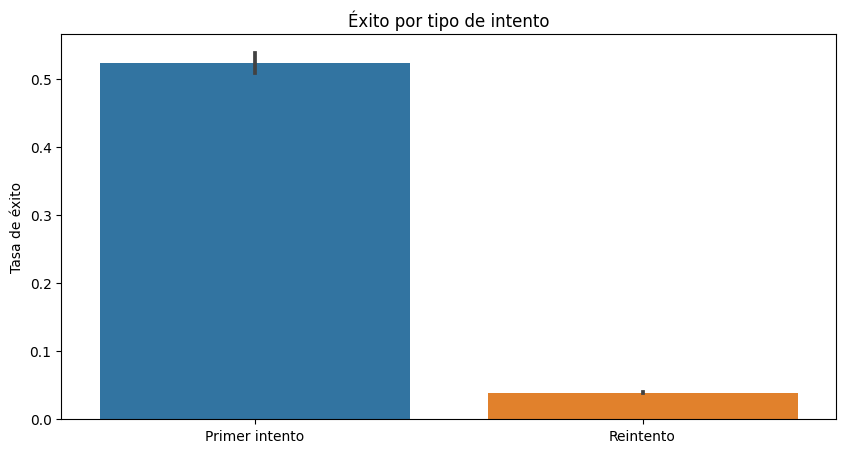

/Users/marcelotrevino/miniforge3/envs/venv1/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


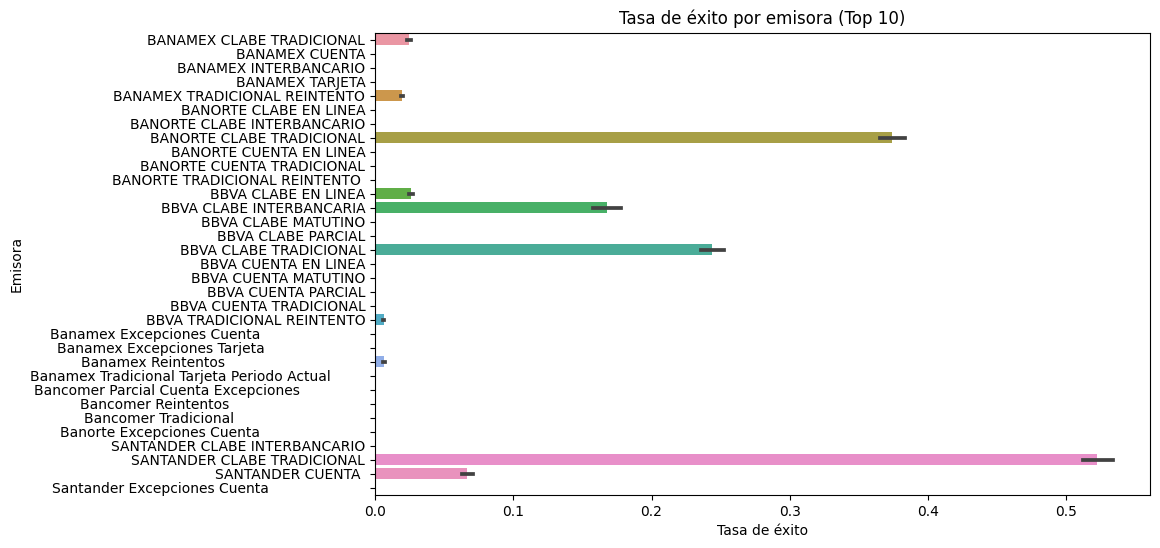

/Users/marcelotrevino/miniforge3/envs/venv1/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


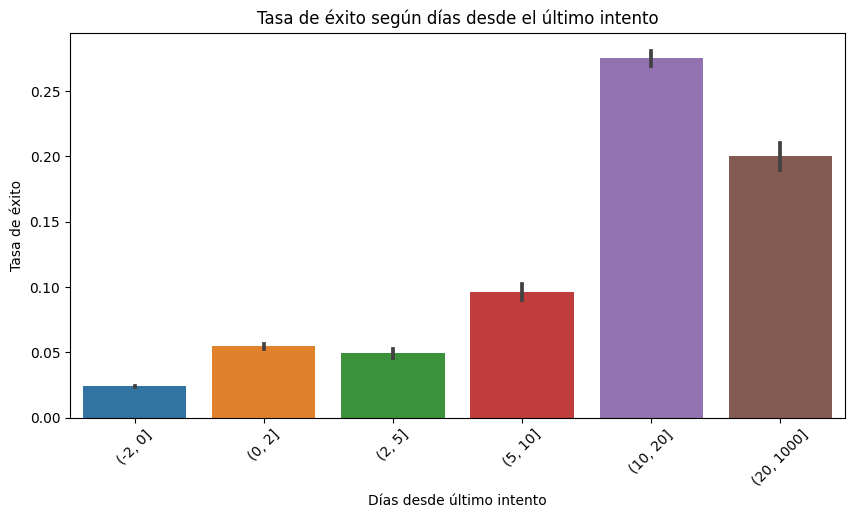

/Users/marcelotrevino/miniforge3/envs/venv1/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


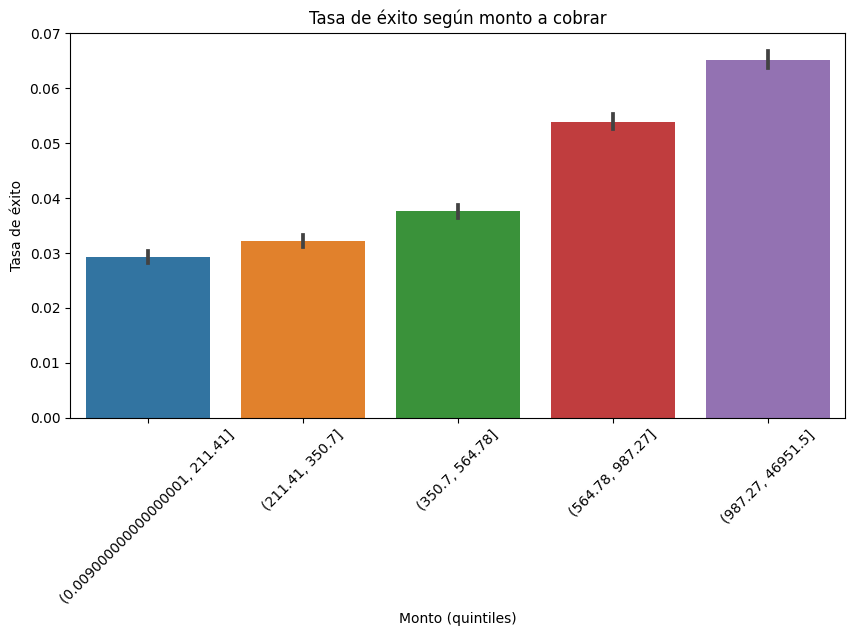

/Users/marcelotrevino/miniforge3/envs/venv1/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


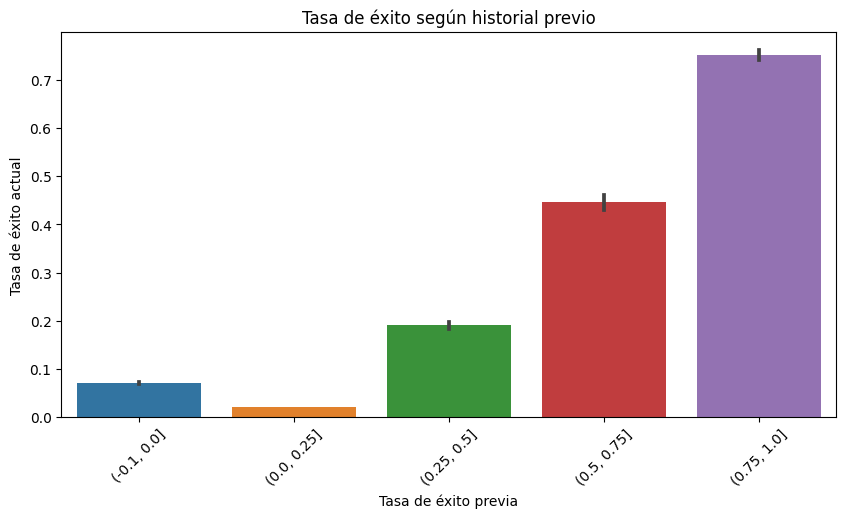

In [8]:
graficar_desempeno(df)

In [11]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def graficar_y_guardar(df, path='graficos/', frac=0.05):
    # Crear carpeta si no existe
    os.makedirs(path, exist_ok=True)

    # Optimizar y muestrear
    df['intento_es_reintento'] = df['intento_es_reintento'].astype('int8')
    df['cobroExitoso'] = df['cobroExitoso'].astype('int8')
    df['NOMBRE_EMISORA'] = df['NOMBRE_EMISORA'].astype('category')
    df_m = df.sample(frac=frac, random_state=42)

    sns.set_style('whitegrid')
    sns.set_palette('deep')

    # Gráfico 1: Primer intento vs Reintento
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_m, x='intento_es_reintento', y='cobroExitoso')
    plt.xticks([0, 1], ['Primer intento', 'Reintento'])
    plt.title('Tasa de éxito por tipo de intento')
    plt.ylabel('Tasa de éxito')
    plt.xlabel('')
    plt.tight_layout()
    plt.savefig(f'{path}exito_por_intento.png', dpi=300)
    plt.close()

    # Gráfico 2: Emisoras
    top_emisoras = df_m['NOMBRE_EMISORA'].value_counts().head(10).index
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_m[df_m['NOMBRE_EMISORA'].isin(top_emisoras)],
                y='NOMBRE_EMISORA', x='cobroExitoso', estimator='mean')
    plt.title('Tasa de éxito por emisora (Top 10)')
    plt.xlabel('Tasa de éxito')
    plt.ylabel('Emisora')
    plt.tight_layout()
    plt.savefig(f'{path}exito_por_emisora.png', dpi=300)
    plt.close()

    # Gráfico 3: Días desde intento anterior
    df_m['grupo_dias'] = pd.cut(df_m['dias_desde_ultimo_intento'], bins=[-2, 0, 2, 5, 10, 20, 1000])
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_m, x='grupo_dias', y='cobroExitoso')
    plt.title('Tasa de éxito según días desde el último intento')
    plt.xlabel('Días desde último intento')
    plt.ylabel('Tasa de éxito')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{path}exito_por_dias.png', dpi=300)
    plt.close()

    # Gráfico 4: Monto
    df_m['rango_monto'] = pd.qcut(df_m['MONTOEXIGIBLE'], q=5, duplicates='drop')
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_m, x='rango_monto', y='cobroExitoso')
    plt.title('Tasa de éxito según monto a cobrar')
    plt.xlabel('Monto (quintiles)')
    plt.ylabel('Tasa de éxito')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{path}exito_por_monto.png', dpi=300)
    plt.close()

    # Gráfico 5: Historial exitoso
    df_m['grupo_historial'] = pd.cut(df_m['tasa_exito_prev'], bins=[-0.1, 0, 0.25, 0.5, 0.75, 1])
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_m, x='grupo_historial', y='cobroExitoso')
    plt.title('Tasa de éxito según historial de cobros')
    plt.xlabel('Tasa de éxito previa')
    plt.ylabel('Tasa de éxito actual')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{path}exito_por_historial.png', dpi=300)
    plt.close()

    print(f"✅ Gráficos guardados en: {path}")

In [12]:
graficar_y_guardar(df)

/Users/marcelotrevino/miniforge3/envs/venv1/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/marcelotrevino/miniforge3/envs/venv1/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/marcelotrevino/miniforge3/envs/venv1/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

✅ Gráficos guardados en: graficos/
